In [1]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn import preprocessing
from keras.callbacks import ReduceLROnPlateau



##################################################
# Params
##################################################

DATA_BASE_FOLDER = '/kaggle/input/ml-project-speech-recognition-challenge'
SAMPLE_RATE = 16000
HOP_LEN = 512

Using TensorFlow backend.


In [97]:
cwd = os.getcwd()

In [98]:
cwd

'/kaggle/working'

# Dataset

The dataset is a reduced version of the [`TensorFlow Speech Commands Dataset`](https://www.tensorflow.org/datasets/catalog/speech_commands) and contains audio waveforms of the words:
- `down`, 
- `go`, 
- `left`, 
- `off`, 
- `on`, 
- `right`, 
- `stop`, 
- `up`.


Train / Validation Split
- 1600 train samples, 200 for each class
- 109 validation samples

In [2]:
##################################################
# Load dataset
##################################################

# Load annotations
df_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))
df_validation = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))
labels = sorted(list(set(df_train['word'].values)))
y_train = df_train['word'].map(lambda w: labels.index(w)).values
y_validation = df_validation['word'].map(lambda w: labels.index(w)).values

# Load audio
audio_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train_audio.npy'))

# Feature Extraction

The speech is a time series signal and a well known strategy for extracting a good representation of the raw audio is to mimic the processing of the auditory system of the humans. A well established feature representation for speech is the so called "log mel-spectrum". This feature in fact, takes into account how humans perceive both the frequencies and the amplitude of the sound logarithmically. If you want to dig more into this topic [here](https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9) you can find some details. 

![auditory-system](https://www.researchgate.net/profile/Morteza_Khaleghi_Meybodi/publication/322343133/figure/fig1/AS:581011472093184@1515535337239/Figure-31-Schematic-of-the-auditory-system-with-its-primary-components-including.png)


For this project these features are precomputed: for each audio waveform of 1 sec duration, the log mel-spectrum is a bi-dimensional representation (frequency vs time) of shape [128, 32]. Here, we first resize the "image" into a [32, 32] matrix and then we flatten the representation into a 32x32 = 1024 vector.

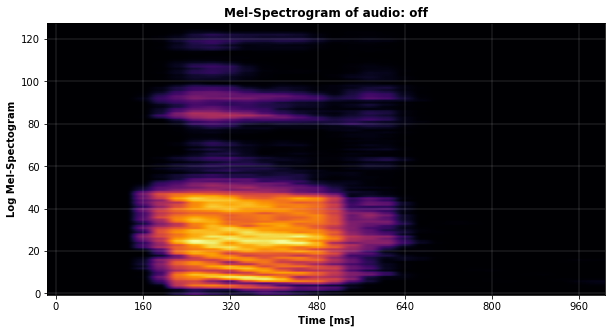

In [3]:
# Load Features
x_train_raw = np.load(os.path.join(DATA_BASE_FOLDER, 'train_feat.npy'))
x_validation_raw = np.load(os.path.join(DATA_BASE_FOLDER, 'validation_feat.npy'))

# Plot audio feature
idx = 1205
time = np.arange(1, SAMPLE_RATE + 1, HOP_LEN) / SAMPLE_RATE
plt.figure(figsize=(10, 5))
plt.title(f'Mel-Spectrogram of audio: {df_train["word"][idx]}', fontweight='bold')
plt.imshow(x_train_raw[idx], aspect='auto', origin='low', cmap='inferno')
xticks = plt.xticks()[0].astype(np.int32)
plt.xticks(xticks[1:-1], [f'{1000 * t:.0f}' for t in time[xticks[1:-1]]])
plt.xlabel('Time [ms]', fontweight='bold')
plt.ylabel('Log Mel-Spectogram', fontweight='bold')
plt.grid(lw=0.4, c='w', alpha=0.4)
plt.show()

# Play audio
ipd.Audio(audio_train[idx], rate=SAMPLE_RATE)

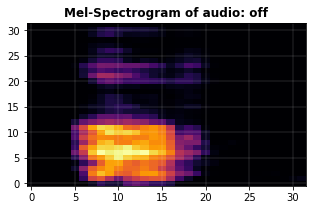

In [4]:
# Resize the features
x_train = []
for x_i in x_train_raw:
    x_train += [cv2.resize(x_i, (32, 32))]
x_train = np.array(x_train)
x_validation = []
for x_i in x_validation_raw:
    x_validation += [cv2.resize(x_i, (32, 32))]
x_validation = np.array(x_validation)

# Plot audio feature
idx = 1205
plt.figure(figsize=(5, 3))
plt.title(f'Mel-Spectrogram of audio: {df_train["word"][idx]}', fontweight='bold')
plt.imshow(x_train[idx], aspect='auto', origin='low', cmap='inferno')
plt.grid(lw=0.4, c='w', alpha=0.4)
plt.show()

# Play audio
ipd.Audio(audio_train[idx], rate=SAMPLE_RATE)

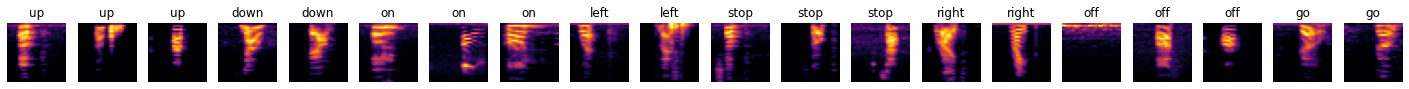

In [5]:
plt.figure(figsize=(25, 25))
j=0
for idx in range(0, 1600, 80):
    plt.subplot(1, 20, j + 1)
    j=j+1
    img = x_train[idx].reshape(32, 32)
    plt.title(f'{labels[y_train[idx]]}')
    plt.imshow(img, cmap='inferno')
    plt.axis('off')
plt.show()

In [6]:
# Flatten the features
x_train = x_train.reshape(x_train.shape[0], -1)
x_validation = x_validation.reshape(x_validation.shape[0], -1)

print(f'Features dimension size: {x_train.shape[-1]}')



Features dimension size: 1024


In [7]:
# import and flatten the test features set
x_test_raw = np.load(os.path.join(DATA_BASE_FOLDER, 'test_feat.npy'))
x_test = []
for x_i in x_test_raw:
    x_test += [cv2.resize(x_i, (32, 32))]
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], -1)
x_test.shape


(136, 1024)

Text(0, 0.5, 'cumulative explained variance')

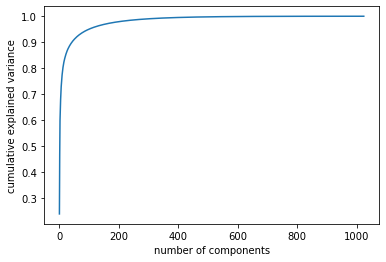

In [8]:
#Principal component analysis
pca=PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# Model

Here you have to implement a model (or more models, for finding the most accurate) for classification.

You can use the [`sklearn`](https://scikit-learn.org/stable/) (or optionally other more advanced frameworks such as [`pytorch`](https://pytorch.org/) or [`tensorflow`](https://www.tensorflow.org/)) package that contains a pool of models already implemented that perform classification. (SVMs, NNs, LR, kNN, ...)

In [143]:
##################################################
# Implement you model here
##################################################

#Neural Network
#tf.random.set_seed(0)
checkpoint_path = "/kaggle/working"
checkpoint_dir = os.path.dirname(checkpoint_path)
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(32, kernel_size=11, padding='same', activation='relu', input_shape=(1024, 1)),
                                    tf.keras.layers.Conv1D(32, kernel_size=11, padding='same', activation='relu', input_shape=(1024, 1)),
                                    tf.keras.layers.MaxPool1D(pool_size=2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1500, activation='relu'),
                                    tf.keras.layers.GaussianDropout(0.5),
                                     tf.keras.layers.Dense(8,activation='softmax')])
                                    
                                    
                                    
    
                                   
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=0.00001)
best_param_model = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
history = model.fit(np.expand_dims(x_train, axis=-1),y_train,epochs=50,validation_data=(np.expand_dims(x_validation, axis=-1),y_validation),verbose=1,callbacks=[reduce_lr, best_param_model])
model.load_weights(checkpoint_path)

Epoch 1/50
50/50 [==============================] - 1s 28ms/step - loss: 5.9966 - accuracy: 0.2025 - val_loss: 1.4253 - val_accuracy: 0.5229 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 1s 29ms/step - loss: 1.4977 - accuracy: 0.4650 - val_loss: 1.1191 - val_accuracy: 0.5963 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 1s 26ms/step - loss: 1.1467 - accuracy: 0.5987 - val_loss: 1.0119 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 4s 86ms/step - loss: 0.8742 - accuracy: 0.6825 - val_loss: 0.7274 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 1s 24ms/step - loss: 0.6763 - accuracy: 0.7606 - val_loss: 0.7925 - val_accuracy: 0.7798 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 2s 32ms/step - loss: 0.5723 - accuracy: 0.7969 - val_loss: 0.4858 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 0s 6ms/step - loss: 0.42

In [133]:
#### creating val_accuracy list for this model
test11_5=[]
tf.random.set_seed(0)
for i in range(21):
    history = model.fit(np.expand_dims(x_train, axis=-1),y_train,epochs=30,validation_data=(np.expand_dims(x_validation, axis=-1),y_validation),verbose=0,callbacks=[reduce_lr, best_param_model])
    model.load_weights(checkpoint_path)
    y_validation_pred=model.predict_classes(np.expand_dims(x_validation, axis=-1))
    test11_5.append(accuracy(y_validation_pred, y_validation))

In [134]:
# trasforming val_accuracy lists in arrays
#for simplicity I deleted the other CNN's and I left just the one that I chose
#the first number stands for the kernel size, the second for the dropout rate
#all the test11s have 2 convolutional layers
test11_4_a=np.array(test11_4)
test11_5_a=np.array(test11_5)
test11_27_a=np.array(test11_27)
test15_4_a=np.array(test15_4)
test15_5_a=np.array(test15_5)
test15_27_a=np.array(test15_27)

In [135]:
#printing val_accuracy means and standard deviations
print('test11_4 :', test11_4_a.mean(), test11_4_a.var()**(1/2))
print('test11_5 :', test11_5_a.mean(), test11_5_a.var()**(1/2))
print('test11_27 :', test11_27_a.mean(), test11_27_a.var()**(1/2))
print('test15_4 :', test15_4_a.mean(), test15_4_a.var()**(1/2))
print('test15_5 :', test15_5_a.mean(), test15_5_a.var()**(1/2))
print('test15_27 :', test15_27_a.mean(), test15_27_a.var()**(1/2))

test11_4 : 0.9126256006989953 0.004581952154522315
test11_5 : 0.9362166885102667 0.014290456298642307
test11_27 : 0.9174311926605506 1.1102230246251565e-16
test15_4 : 0.9069462647444297 0.004280453897393055
test15_5 : 0.9204892966360855 0.004324812117348888
test15_27 : 0.8990825688073397 2.220446049250313e-16


[Text(0, 0.5, 'lr'), Text(0.5, 0, 'epoch')]

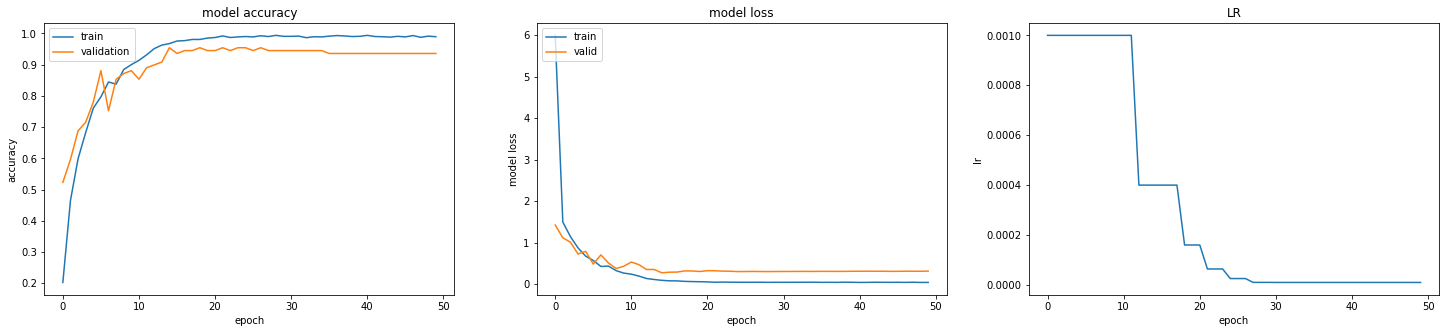

In [144]:
fig, (p1,p2,p3) = plt.subplots(1, 3,figsize=(25,5))
p1.plot(history.history['accuracy'])
p1.plot(history.history['val_accuracy'])
p1.set_title("model accuracy")
p1.set(xlabel='epoch',ylabel="accuracy")
p1.legend(['train', 'validation'], loc='upper left')

p2.plot(history.history['loss'])
p2.plot(history.history['val_loss'])
p2.set_title("model loss")
p2.set(xlabel='epoch',ylabel="model loss")
p2.legend(['train', 'valid'], loc='upper left')

p3.plot(history.history['lr'])
p3.set_title('LR')
p3.set(xlabel="epoch",ylabel='lr')

In [145]:
#Suport Vector Machines
pca=PCA(30, svd_solver='randomized', whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced')
model_svc = make_pipeline(pca, svc)
projected = model_svc.fit(x_train, y_train)
ypredicted = model_svc.predict(x_validation)
accuracy(ypredicted, y_validation)






0.7981651376146789

Random forest

In [146]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
pca=PCA(30, svd_solver='randomized', whiten=True)
rfc = RandomForestClassifier(n_estimators=1500, random_state=0)
model_rfc = make_pipeline(pca, rfc)
projected = model_rfc.fit(x_train, y_train)
ypredicted = model_rfc.predict(x_validation)
accuracy(ypredicted, y_validation)



0.7064220183486238

Logistic regression

In [147]:
#logistic regression
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(solver='newton-cg',penalty= 'l2', random_state=0, max_iter = 10000)
pca=PCA(30, svd_solver='randomized', whiten=True)
model_lgr = make_pipeline(pca, lgr)
projected = model_lgr.fit(x_train, y_train)
ypredicted = model_lgr.predict(x_validation)
accuracy(ypredicted, y_validation)

0.6055045871559633

KNN model

In [148]:
#knn neighbors
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier()
pca=PCA(30, svd_solver='randomized', whiten=True)
clf = neighbors.KNeighborsClassifier()
model_lgr = make_pipeline(pca, clf)
projected = model_lgr.fit(x_train, y_train)
ypredicted = model_lgr.predict(x_validation)
accuracy(ypredicted, y_validation)



0.7339449541284404

# Evaluation

In [149]:
##################################################
# Evaluate the model here
##################################################

# Use this function to evaluate your model
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.
y_train_pred=model.predict_classes(np.expand_dims(x_train, axis=-1))
y_validation_pred=model.predict_classes(np.expand_dims(x_validation, axis=-1))

train_accuracy=accuracy(y_train_pred, y_train)
validation_accuracy=accuracy(y_validation_pred, y_validation)
print("train accurancy: ",train_accuracy)
print("valid accurancy: ",validation_accuracy)


train accurancy:  0.98
valid accurancy:  0.9541284403669725


# Send the submission for the challenge

In [150]:
##################################################
# Save your test prediction in y_test_pred
##################################################

y_test_pred = model.predict_classes(np.expand_dims(x_test, axis=-1))

# Create submission
submission = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'sample_submission.csv'))
if y_test_pred is not None:
    submission['word'] = [labels[int(y_i)] for y_i in y_test_pred]
submission.to_csv('my_submission.csv', index=False)